# Modelling optimization

- Create new baseline regression models using the preprocessed training dataset and different regression algorithms (regression trees, SVR, k-NN Regression..)
- Evaluate baseline models with your preprocessed validation dataset *
- Optimize your baseline models / create further model versions
    - Hyper-parameter Tuning: Change the hyper-parameters of your algorithms (e.g. „kernel“ in case of
    SVR)
    - Feature Selection: Remove features, which are not helpful for your model
- Evaluate each model version with your preprocessed validation dataset * and store evaluation results in an evaluation data frame
- Finally, check your best model, applying it to the preprocessed test dataset*.
- Also analyze feature importance within your best model **
- Within the validation and test dataset, you are not allowed to remove examples / rows or
change label values
- Visualize your evaluation results
- Document and present the learnings from the coding for this task
- Keep grading criteria for this task in mind!

\* based on accuracies and f1 measure

** based on p-values or other appropriate measures

# Import libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV


# Load data

In [7]:
# Load training and testing datasets with ; separator
df_train_prep = pd.read_csv('BikeRentalDaily_train_prepared_encoded.csv', sep=',')
df_test_prep = pd.read_csv('BikeRentalDaily_test_prepared_encoded.csv', sep=',')

# df_train_prep = pd.read_csv('BikeRentalDaily_train_prepared.csv', sep=',')
# df_test_prep = pd.read_csv('BikeRentalDaily_test_prepared.csv', sep=',')

print("Training Data Shape:", df_train_prep.shape)
print("Testing Data Shape:", df_test_prep.shape)

df_train_prep.head()

Training Data Shape: (596, 17)
Testing Data Shape: (132, 17)


,yr,holiday,workingday,temp,hum,windspeed,leaflets,price reduction,cnt,weathersit_2,weathersit_3,season_sin,season_cos,mnth_sin,mnth_cos,weekday_sin,weekday_cos
0,0,0,0,13.7667,78.757251,0.160446,755,0,985,True,False,1.0,6.123234e-17,0.5,0.866025,-0.781831,0.623490
1,0,0,0,14.5391,64.769438,0.248539,837,1,801,True,False,1.0,6.123234e-17,0.5,0.866025,-0.781831,0.623490
2,0,0,1,7.8546,31.781978,0.248309,829,0,1349,False,False,1.0,6.123234e-17,0.5,0.866025,0.781831,0.623490
3,0,0,1,8.0000,51.303431,0.160296,734,0,1562,False,False,1.0,6.123234e-17,0.5,0.866025,0.974928,-0.222521
4,0,0,1,9.0783,31.741702,0.186900,745,0,1600,False,False,1.0,6.123234e-17,0.5,0.866025,0.433884,-0.900969


# Stratify train and validation sets

In [8]:
# 1. Split the initial df_train_final into Training and Validation sets
# We'll use 20% for validation and set a random_state for reproducibility
train_set, val_set = train_test_split(
    df_train_prep, 
    test_size=0.2, 
    random_state=42,
    stratify=df_train_prep[['holiday', 'workingday', 'weathersit_2', 'weathersit_3']]
    # stratify=df_train_prep[['holiday', 'workingday']]
    )

In [9]:
# Separate Features (X) and Target (y) for all three sets
# Training Set (used to fit the model)
X_train = train_set.drop(columns=['cnt'])
y_train = train_set['cnt']

# Validation Set (used to evaluate performance during training)
X_val = val_set.drop(columns=['cnt'])
y_val = val_set['cnt']

# Test Set
X_test = df_test_prep.drop(columns=['cnt'])
y_test = df_test_prep['cnt']

# Auxiliar functions

In [10]:
# Initialize an empty list to store model performance
model_performance_list = []

def record_performance(model_name, y_true, y_pred):
    """Helper function to store metrics in our list"""
    perf = {
        "Model": model_name,
        "R-squared": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }
    model_performance_list.append(perf)
    return pd.DataFrame(model_performance_list)

# Baseline models

## Linear Regression

In [11]:
# Train the model on the TRAINING set
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Evaluate on the VALIDATION set
y_val_pred_lr = lr_model.predict(X_val)

# Record and display current results
df_results = record_performance("Linear Regression (Baseline)", y_val, y_val_pred_lr)

## Regression Tree

In [12]:
# Train the model on the TRAINING set
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
# Evaluate on the VALIDATION set
y_val_pred_dt = dt_model.predict(X_val)

# Record and display current results
df_results = record_performance("Decision Tree (Baseline)", y_val, y_val_pred_dt)

## Support Vector Regressor

In [13]:
# Initialize the SVR model
# We'll use the default 'rbf' kernel for the baseline
svr_model = SVR(kernel='linear')

svr_model.fit(X_train, y_train)
# 3. Predict on validation set
y_val_pred_svr = svr_model.predict(X_val)
# 4. Record and display results using your tracking system
df_results = record_performance("SVR (Baseline/Linear)", y_val, y_val_pred_svr)

## KNN

In [14]:
# 1. Initialize the k-NN model
# Default is n_neighbors=5
knn_regressor = KNeighborsRegressor()

# 2. Train the model
knn_regressor.fit(X_train, y_train)

# 3. Predict on validation set
y_val_pred_knn = knn_regressor.predict(X_val)

# 4. Record and display results
df_results = record_performance("k-NN (Baseline)", y_val, y_val_pred_knn)

## Random Forest

In [15]:
# Initialize the Random Forest model
# We'll use 100 trees (default) and a fixed random_state
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_regressor.predict(X_val)

# Record and display results
df_results = record_performance("Random Forest (Baseline)", y_val, y_val_pred_rf)

## XGBoost

In [16]:
# Initialize the XGBoost model
# We'll use default parameters for the baseline
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X_train, y_train)

# Predict on validation set
y_val_pred_xgb = xgb_regressor.predict(X_val)

# Record and display results
df_results = record_performance("XGBoost (Baseline)", y_val, y_val_pred_xgb)

## LightGBM

In [17]:
# Initialize the LightGBM model
# 'verbosity=-1' helps to keep the output clean of non-critical warnings
lgbm_regressor = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)
lgbm_regressor.fit(X_train, y_train)

# Predict on validation set
y_val_pred_lgbm = lgbm_regressor.predict(X_val)

# Record and display results
df_results = record_performance("LightGBM (Baseline)", y_val, y_val_pred_lgbm)

## Show baseline results

In [18]:
df_results = df_results.sort_values('Model').reset_index(drop=True)
df_results

,Model,R-squared,RMSE
0,Decision Tree (Baseline),0.812058,875.379822
1,LightGBM (Baseline),0.425216,1530.866890
2,Linear Regression (Baseline),0.755890,997.649924
3,Random Forest (Baseline),0.627507,1232.378788
4,SVR (Baseline/Linear),0.493942,1436.432553
5,XGBoost (Baseline),0.409283,1551.939996
6,k-NN (Baseline),-0.438931,2422.173274


# Feature Selection

In [19]:
#seperate numeric and nominal features
numeric_features = train_set.select_dtypes(include=[np.number]).copy()
nominal_features = train_set.select_dtypes(include=[object]).copy()

#seperate label from numeric features
label = numeric_features.pop("cnt")

In [20]:
# numeric_features
# nominal_features
# label

## Feature selection for numeric features using correlation and colinearity

In [21]:
#caluclate correlation of numeric features with label
numeric_features_corr = numeric_features.corrwith(label)
numeric_features_corr

yr                 0.328595
holiday           -0.048701
workingday        -0.037937
temp               0.355595
hum               -0.059111
windspeed         -0.137221
leaflets           0.055338
price reduction    0.018223
season_sin        -0.321486
season_cos        -0.093449
mnth_sin          -0.193558
mnth_cos          -0.255262
weekday_sin       -0.076900
weekday_cos        0.025231
dtype: float64

In [22]:
#keep 10 best numeric features
numeric_features = numeric_features[numeric_features_corr.abs().sort_values(ascending=False).index[:10]]
numeric_features_corr = numeric_features.corrwith(label)
numeric_features_corr

temp           0.355595
yr             0.328595
season_sin    -0.321486
mnth_cos      -0.255262
mnth_sin      -0.193558
windspeed     -0.137221
season_cos    -0.093449
weekday_sin   -0.076900
hum           -0.059111
leaflets       0.055338
dtype: float64

In [23]:
#calculate colinearity of remaining numeric features
numeric_features_corr = numeric_features.corr()
# Displaying correlations as a heatmap / correlation matrix
numeric_features_corr.style.background_gradient(cmap ='coolwarm')

,temp,yr,season_sin,mnth_cos,mnth_sin,windspeed,season_cos,weekday_sin,hum,leaflets
temp,1.000000,0.005844,-0.783435,-0.787125,-0.437453,-0.168852,-0.285889,0.030873,0.134583,0.041488
yr,0.005844,1.000000,0.038741,0.019235,0.029806,-0.021674,-0.003270,0.002721,-0.090454,-0.048025
season_sin,-0.783435,0.038741,1.000000,0.557551,0.691172,0.198530,0.000574,-0.021797,-0.163604,-0.048219
mnth_cos,-0.787125,0.019235,0.557551,1.000000,-0.013040,0.032376,0.693427,-0.015121,0.045899,-0.056479
mnth_sin,-0.437453,0.029806,0.691172,-0.013040,1.000000,0.227589,-0.539720,-0.023699,-0.232511,-0.042318
windspeed,-0.168852,-0.021674,0.198530,0.032376,0.227589,1.000000,-0.131625,0.041658,-0.232727,-0.040705
season_cos,-0.285889,-0.003270,0.000574,0.693427,-0.539720,-0.131625,1.000000,-0.012286,0.125298,-0.044229
weekday_sin,0.030873,0.002721,-0.021797,-0.015121,-0.023699,0.041658,-0.012286,1.000000,0.094819,-0.073034
hum,0.134583,-0.090454,-0.163604,0.045899,-0.232511,-0.232727,0.125298,0.094819,1.000000,-0.017925
leaflets,0.041488,-0.048025,-0.048219,-0.056479,-0.042318,-0.040705,-0.044229,-0.073034,-0.017925,1.000000


In [24]:
#apply a mask to highlight colinearity values > 0.5
numeric_features_corr_strong = (abs(numeric_features_corr) > 0.5)*1
# Displaying correlations as a heatmap / correlation matrix
numeric_features_corr_strong.style.background_gradient(cmap ='coolwarm')

,temp,yr,season_sin,mnth_cos,mnth_sin,windspeed,season_cos,weekday_sin,hum,leaflets
temp,1,0,1,1,0,0,0,0,0,0
yr,0,1,0,0,0,0,0,0,0,0
season_sin,1,0,1,1,1,0,0,0,0,0
mnth_cos,1,0,1,1,0,0,1,0,0,0
mnth_sin,0,0,1,0,1,0,1,0,0,0
windspeed,0,0,0,0,0,1,0,0,0,0
season_cos,0,0,0,1,1,0,1,0,0,0
weekday_sin,0,0,0,0,0,0,0,1,0,0
hum,0,0,0,0,0,0,0,0,1,0
leaflets,0,0,0,0,0,0,0,0,0,1


In [25]:
#calculate multicollinearity of numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(df):
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif
calc_vif(numeric_features)

,features,VIF Factor
0,temp,26.912763
1,yr,1.988203
2,season_sin,5.095499
3,mnth_cos,7.179130
4,mnth_sin,4.595088
5,windspeed,6.312709
6,season_cos,4.345217
7,weekday_sin,1.042355
8,hum,11.696460
9,leaflets,15.494012


In [26]:
#remove leaflets from numeric features
numeric_features = numeric_features.drop(columns=['leaflets'])
#recalculate multicollinearity of numeric features
calc_vif(numeric_features)

,features,VIF Factor
0,temp,19.495526
1,yr,1.987674
2,season_sin,5.053133
3,mnth_cos,6.740714
4,mnth_sin,4.568104
5,windspeed,5.986060
6,season_cos,4.326824
7,weekday_sin,1.029282
8,hum,11.259967


In [27]:
#remove hum from numeric features
numeric_features = numeric_features.drop(columns=['hum'])
#recalculate multicollinearity of numeric features
calc_vif(numeric_features)

,features,VIF Factor
0,temp,7.480327
1,yr,1.976440
2,season_sin,5.051065
3,mnth_cos,5.437791
4,mnth_sin,4.542763
5,windspeed,5.983069
6,season_cos,4.269576
7,weekday_sin,1.024368


In [28]:
#show remaining correlations with label
numeric_features_corr = numeric_features.corrwith(label)
numeric_features_corr

temp           0.355595
yr             0.328595
season_sin    -0.321486
mnth_cos      -0.255262
mnth_sin      -0.193558
windspeed     -0.137221
season_cos    -0.093449
weekday_sin   -0.076900
dtype: float64

In [29]:
numeric_features.shape

(476, 8)

##  Apply the feture selection to validation and test set

In [30]:
# 1. Combine the names of your selected numeric and nominal features
# This ensures we keep exactly what you decided on during analysis
selected_features = list(numeric_features.columns) + list(nominal_features.columns)

print("Final Selected Features:", selected_features)

# 2. Update X_train and X_val to use ONLY these features
X_train_orig = X_train.copy()
X_train = train_set[selected_features]
x_val_orig = val_set.copy()
X_val = val_set[selected_features]
x_test_orig = df_test_prep.copy()
X_test = df_test_prep[selected_features]

print(f"X_train_orig shape: {X_train_orig.shape}")
print(f"X_val_orig shape: {x_val_orig.shape}")
print(f"X_test_orig shape: {x_test_orig.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Final Selected Features: ['temp', 'yr', 'season_sin', 'mnth_cos', 'mnth_sin', 'windspeed', 'season_cos', 'weekday_sin']
X_train_orig shape: (476, 16)
X_val_orig shape: (120, 17)
X_test_orig shape: (132, 17)
X_train shape: (476, 8)
X_val shape: (120, 8)
X_test shape: (132, 8)


# Model Hyperparameter Optimization

## Linear Regression

In [31]:
# 1. Define the parameter grid for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# 2. Initialize GridSearchCV
# Using 5-fold cross-validation and R-squared as the scoring metric
grid_lr = GridSearchCV(LinearRegression(), param_grid_lr, cv=5, scoring='r2')

# 3. Train on the TRAINING set
grid_lr.fit(X_train, y_train)

# 4. Get the best estimator
best_lr_model = grid_lr.best_estimator_
print("Best Parameters:", grid_lr.best_params_)

# 5. Evaluate on the VALIDATION set using the best model
y_val_pred_lr_opt = best_lr_model.predict(X_val)

# 6. Record and display results
df_results = record_performance("Linear Regression (Optimized)", y_val, y_val_pred_lr_opt)

Best Parameters: {'fit_intercept': False, 'positive': True}


## Regression Tree

In [32]:
# 1. Define the parameter grid for the Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# 2. Initialize GridSearchCV
# Scoring by R-squared is common for regression
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=5, scoring='r2')

# 3. Train on the TRAINING set
grid_dt.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_dt.best_params_)
best_dt_model = grid_dt.best_estimator_

# 5. Evaluate on the VALIDATION set
y_val_pred_dt_opt = best_dt_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("Decision Tree (Optimized)", y_val, y_val_pred_dt_opt)

Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}


## Support Vector Regressor

In [33]:
# 1. Define the parameter grid for SVR
# SVR is sensitive to the scale of data and its hyperparameters.
param_grid_svr = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'epsilon': [0.01, 0.1, 1],         # Specifies the epsilon-tube within which no penalty is associated
    'kernel': ['linear', 'rbf'],       # Trying both linear and non-linear patterns
    'gamma': ['scale', 'auto']         # Kernel coefficient for 'rbf'
}

# 2. Initialize GridSearchCV
# Using n_jobs=-1 will use all your CPU cores to speed up the search
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='r2', n_jobs=-1)

# 3. Train on the TRAINING set
grid_svr.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_svr.best_params_)
best_svr_model = grid_svr.best_estimator_

# 5. Evaluate on the VALIDATION set
y_val_pred_svr_opt = best_svr_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("SVR (Optimized)", y_val, y_val_pred_svr_opt)

Best Parameters: {'C': 100, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear'}


## KNN

In [34]:
# 1. Define the parameter grid for k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['uniform', 'distance'],  # 'distance' weight points by the inverse of their distance
    'p': [1, 2]                          # 1 = Manhattan distance, 2 = Euclidean distance
}

# 2. Initialize GridSearchCV
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='r2', n_jobs=-1)

# 3. Train on the TRAINING set
grid_knn.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_knn.best_params_)
best_knn_model = grid_knn.best_estimator_

# 5. Evaluate on the VALIDATION set
y_val_pred_knn_opt = best_knn_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("k-NN (Optimized)", y_val, y_val_pred_knn_opt)

Best Parameters: {'n_neighbors': 21, 'p': 1, 'weights': 'uniform'}


## Random Forest

In [35]:
# 1. Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Depth of each tree
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None] # Number of features to consider at each split
}

# 2. Initialize GridSearchCV
# Using n_jobs=-1 is highly recommended as Random Forest is computationally expensive
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

# 3. Train on the TRAINING set
grid_rf.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# 5. Evaluate on the VALIDATION set
y_val_pred_rf_opt = best_rf_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("Random Forest (Optimized)", y_val, y_val_pred_rf_opt)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


## XGBoost

In [36]:
# 1. Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],           # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of a tree
    'subsample': [0.7, 0.8, 1.0],         # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0]   # Fraction of features used per tree
}

# 2. Initialize GridSearchCV
# n_jobs=-1 helps speed up the process
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)

# 3. Train on the TRAINING set
grid_xgb.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_xgb.best_params_)
best_xgb_model = grid_xgb.best_estimator_

# 5. Evaluate on the VALIDATION set using the optimized model
y_val_pred_xgb_opt = best_xgb_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("XGBoost (Optimized)", y_val, y_val_pred_xgb_opt)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


## LightGBM

In [ ]:
# 1. Define the parameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],           # Main parameter to control complexity
    'max_depth': [-1, 5, 10],            # -1 means no limit
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# 2. Initialize GridSearchCV
# Using verbosity=-1 in the model helps keep the logs clean during the search
grid_lgbm = GridSearchCV(
    LGBMRegressor(random_state=42, verbosity=-1), 
    param_grid_lgbm, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1
)

# 3. Train on the TRAINING set
grid_lgbm.fit(X_train, y_train)

# 4. Get the best parameters and the best model
print("Best Parameters:", grid_lgbm.best_params_)
best_lgbm_model = grid_lgbm.best_estimator_

# 5. Evaluate on the VALIDATION set
y_val_pred_lgbm_opt = best_lgbm_model.predict(X_val)

# 6. Record and display the results
df_results = record_performance("LightGBM (Optimized)", y_val, y_val_pred_lgbm_opt)

# Show Optimized Results

In [ ]:
df_results = df_results.sort_values('Model').reset_index(drop=True)
df_results

,Model,R-squared,RMSE
0,Decision Tree (Baseline),0.812058,875.379822
1,Decision Tree (Optimized),-2.261356,3646.567520
2,LightGBM (Baseline),0.425216,1530.866890
3,LightGBM (Optimized),0.538798,1371.294246
4,Linear Regression (Baseline),0.755890,997.649924
5,Linear Regression (Optimized),0.722632,1063.441733
6,Random Forest (Baseline),0.627507,1232.378788
7,Random Forest (Optimized),0.668771,1162.114812
8,SVR (Baseline/Linear),0.493942,1436.432553
9,SVR (Optimized),0.760856,987.450102


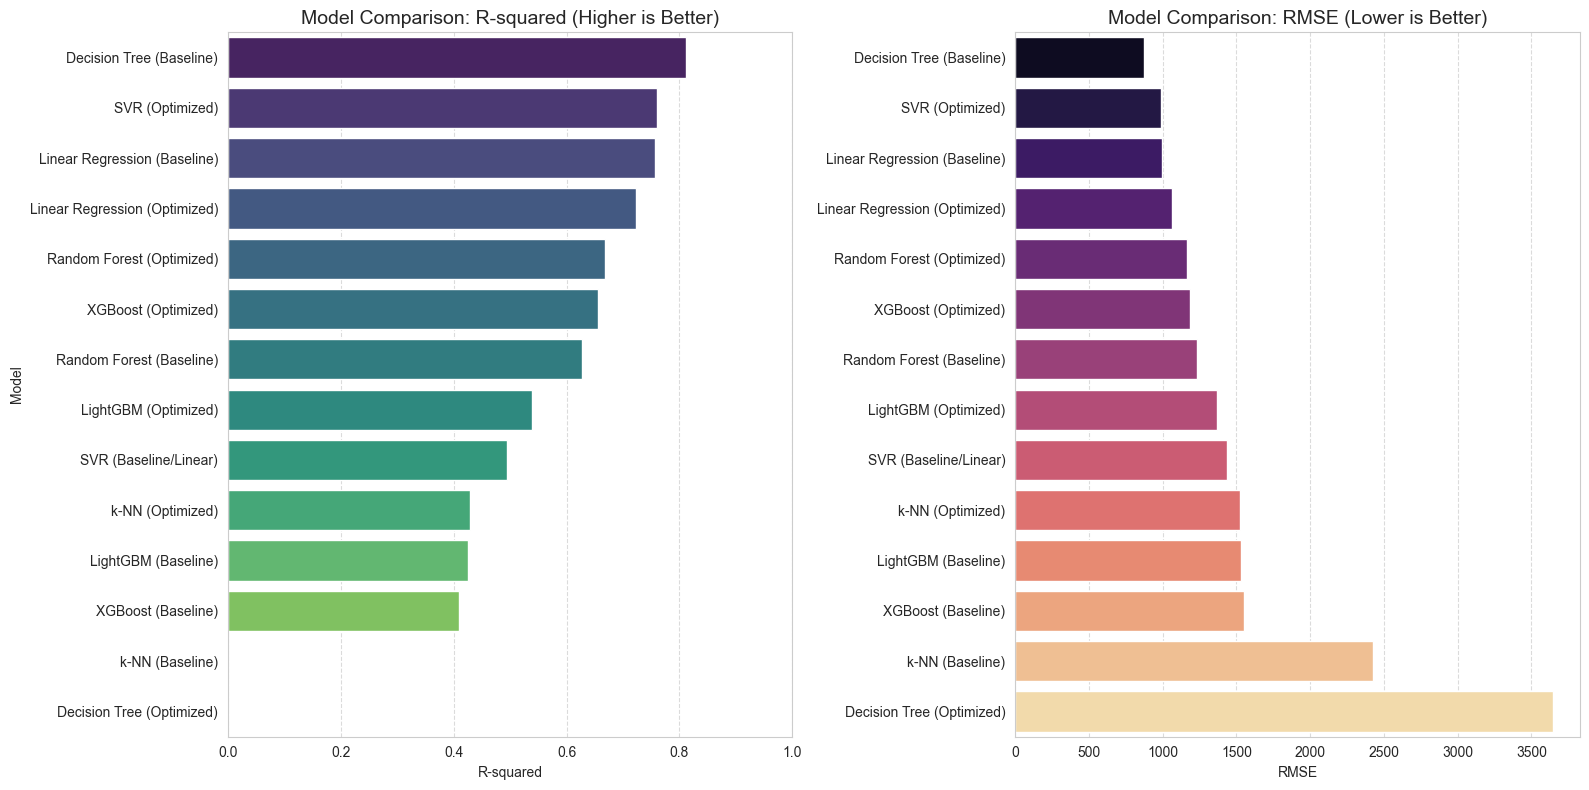

In [ ]:
# 1. Sort results by R-squared for better visualization
df_viz = df_results.sort_values(by="R-squared", ascending=False)
# 2. Set up the plotting area (2 subplots: R-squared and RMSE)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# --- Plot 1: R-squared (Higher is Better) ---
# Added hue="Model" and legend=False to resolve the warning
sns.barplot(data=df_viz, x="R-squared", y="Model", ax=axes[0], hue="Model", palette="viridis", legend=False)
axes[0].set_title("Model Comparison: R-squared (Higher is Better)", fontsize=14)
axes[0].set_xlim(0, 1.0) 
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# --- Plot 2: RMSE (Lower is Better) ---
sns.barplot(data=df_viz, x="RMSE", y="Model", ax=axes[1], hue="Model", palette="magma", legend=False)
axes[1].set_title("Model Comparison: RMSE (Lower is Better)", fontsize=14)
axes[1].set_ylabel("") 
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Show Feature Importance

In [ ]:
best_model_name = df_results.sort_values(by="R-squared", ascending=False).iloc[1]['Model']
print(f"Your best performing model is: {best_model_name}")

# --- SELECT YOUR BEST MODEL HERE ---
# Example: If XGBoost was best, use grid_xgb.best_estimator_ or best_xgb_model
winner_model = best_svr_model 

Your best performing model is: SVR (Optimized)


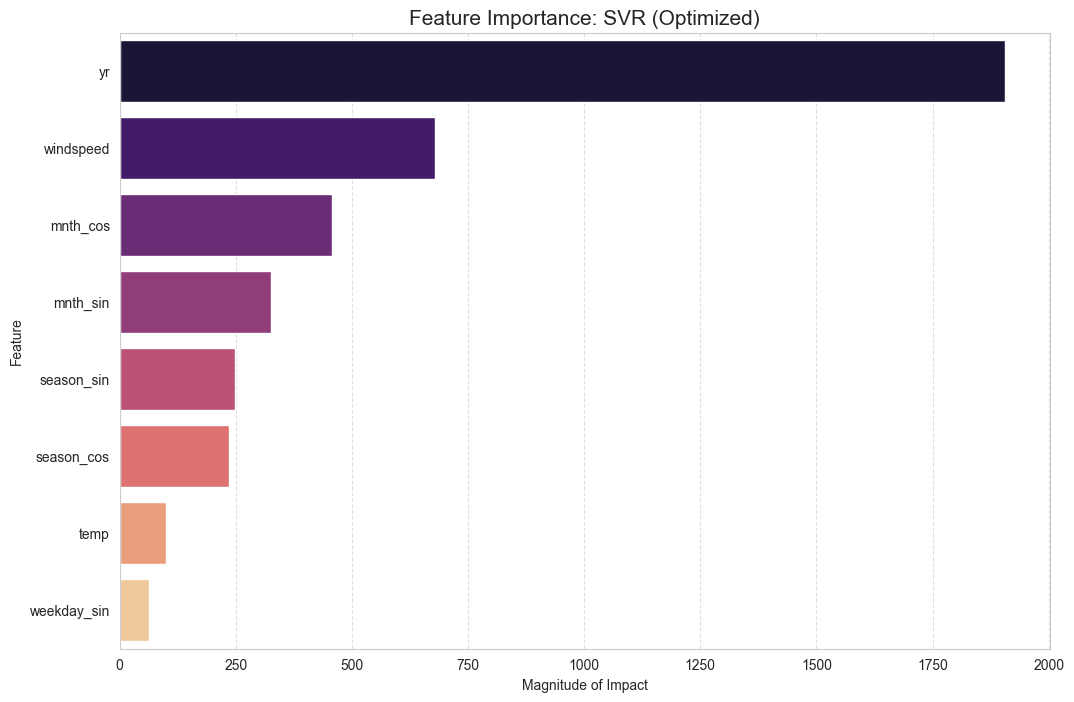

In [ ]:
feature_names = X_train.columns

# 1. If it's a Tree-Based Model (Random Forest, XGBoost, LightGBM, Decision Tree)
if hasattr(winner_model, 'feature_importances_'):
    importances = winner_model.feature_importances_
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# 2. If it's a Linear Model (Linear Regression, SVR with linear kernel)
elif hasattr(winner_model, 'coef_'):
    # Note: Coefficients need to be absolute to show magnitude of impact
    importances = np.abs(winner_model.coef_.flatten())
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# 3. If it's a model without direct attributes (like SVR RBF or KNN)
else:
    print("Calculating Permutation Importance (this may take a moment)...")
    result = permutation_importance(winner_model, X_val, y_val, n_repeats=10, random_state=42)
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})

# --- Visualization ---
df_imp = df_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_imp, x='Importance', y='Feature', hue='Feature', palette='magma', legend=False)
plt.title(f"Feature Importance: {best_model_name}", fontsize=15)
plt.xlabel("Magnitude of Impact")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Test Best Models

In [ ]:
# Re-initialize an empty list to store model performance
model_performance_list = []

## Test Decission Tree (Baseline)

In [ ]:
y_test_pred_dt = dt_model.predict(x_test_orig)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_dt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_dt)):.2f}")

# 6. Record and display the results
df_results = record_performance("Decision Tree (Baseline) - Test", y_test, y_test_pred_dt)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cnt


## Test SVR (optimized)

In [ ]:
y_test_pred_svr = best_svr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_svr):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_svr)):.2f}")


# 6. Record and display the results
df_results = record_performance("Random Forest (Optimized) - Test", y_test, y_test_pred_svr)

--- Test Model Performance ---
R-squared (Test): 0.3852
RMSE (Test): 2435.99


## Test Random Forest (optimized)

In [ ]:
y_test_pred_rf = best_rf_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f}")

# 6. Record and display the results
df_results = record_performance("Random Forest (Optimized) - Test", y_test, y_test_pred_rf)

--- Test Model Performance ---
R-squared (Test): 0.4777
RMSE (Test): 2245.29


## Test Linear Regression (Baseline)

In [ ]:
y_test_pred_lr = lr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_lr):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_lr)):.2f}")

# 6. Record and display the results
df_results = record_performance("Linear Regression (Baseline) - Test", y_test, y_test_pred_lr)

--- Test Model Performance ---
R-squared (Test): 0.3875
RMSE (Test): 2431.54


## Test Linear Regression (Optimized)

In [ ]:
y_test_pred_lr_opt = best_lr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_lr_opt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_lr_opt)):.2f}")

# 6. Record and display the results
df_results = record_performance("Linear Regression (Optimized) - Test", y_test, y_test_pred_lr_opt)

--- Test Model Performance ---
R-squared (Test): 0.3889
RMSE (Test): 2428.77


## Test XGBoost (Optimized)

In [ ]:
y_test_pred_xgb_opt = best_xgb_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_xgb_opt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_opt)):.2f}")

# 6. Record and display the results
df_results = record_performance("XGBoost (Optimized) - Test", y_test, y_test_pred_xgb_opt)

--- Test Model Performance ---
R-squared (Test): 0.4009
RMSE (Test): 2404.75


# Show Test Model Performance

In [ ]:
df_results = df_results.sort_values('Model').reset_index(drop=True)
df_results

,Model,R-squared,RMSE
0,Decision Tree (Baseline) - Test,-1.531849,4943.609275
1,Linear Regression (Baseline) - Test,0.387492,2431.538015
2,Linear Regression (Optimized) - Test,0.388886,2428.769424
3,Random Forest (Optimized) - Test,0.385248,2435.988375
4,Random Forest (Optimized) - Test,0.477729,2245.294476
5,XGBoost (Optimized) - Test,0.400915,2404.747700


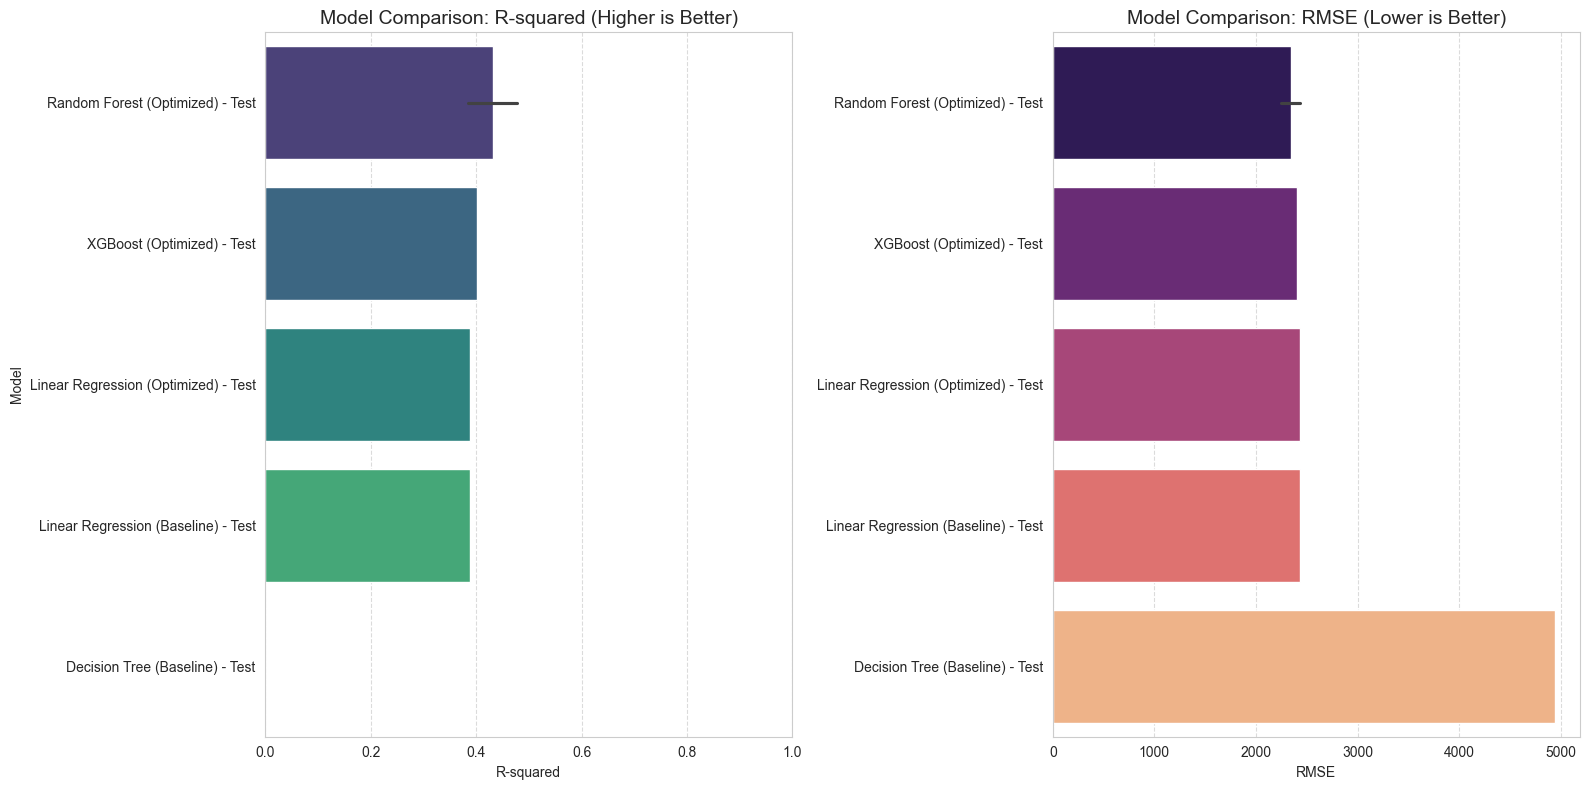

In [ ]:
# 1. Sort results by R-squared for better visualization
df_viz = df_results.sort_values(by="R-squared", ascending=False)
# 2. Set up the plotting area (2 subplots: R-squared and RMSE)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# --- Plot 1: R-squared (Higher is Better) ---
# Added hue="Model" and legend=False to resolve the warning
sns.barplot(data=df_viz, x="R-squared", y="Model", ax=axes[0], hue="Model", palette="viridis", legend=False)
axes[0].set_title("Model Comparison: R-squared (Higher is Better)", fontsize=14)
axes[0].set_xlim(0, 1.0) 
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# --- Plot 2: RMSE (Lower is Better) ---
sns.barplot(data=df_viz, x="RMSE", y="Model", ax=axes[1], hue="Model", palette="magma", legend=False)
axes[1].set_title("Model Comparison: RMSE (Lower is Better)", fontsize=14)
axes[1].set_ylabel("") 
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

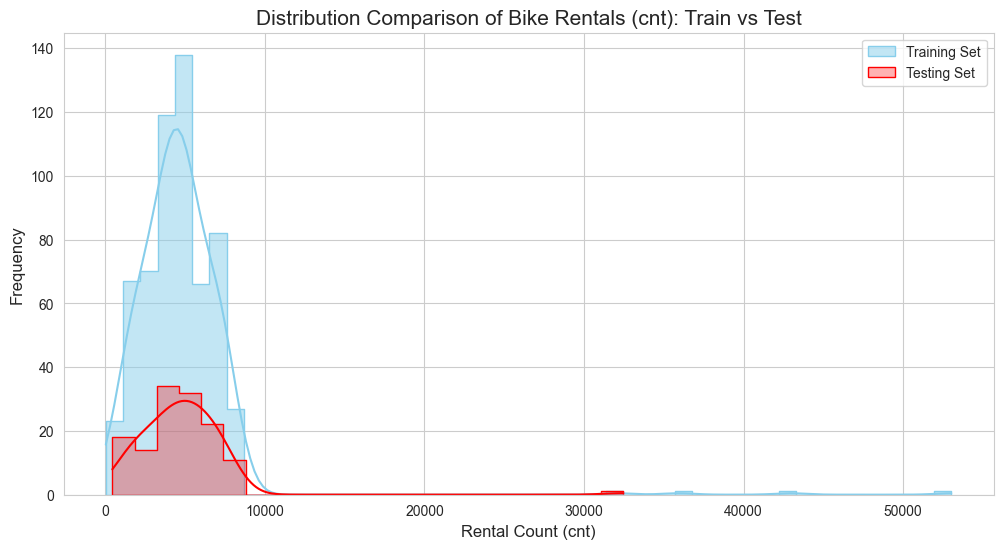

In [ ]:
# Set the visual style
sns.set_style("whitegrid")
# Create the figure
plt.figure(figsize=(12, 6))
# 1. Plot the Train distribution
sns.histplot(df_train_prep['cnt'], kde=True, color="skyblue", label="Training Set", element="step")
# 2. Plot the Test distribution (using a different color and transparency)
sns.histplot(df_test_prep['cnt'], kde=True, color="red", label="Testing Set", element="step", alpha=0.3)
# Add titles and labels
plt.title('Distribution Comparison of Bike Rentals (cnt): Train vs Test', fontsize=15)
plt.xlabel('Rental Count (cnt)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

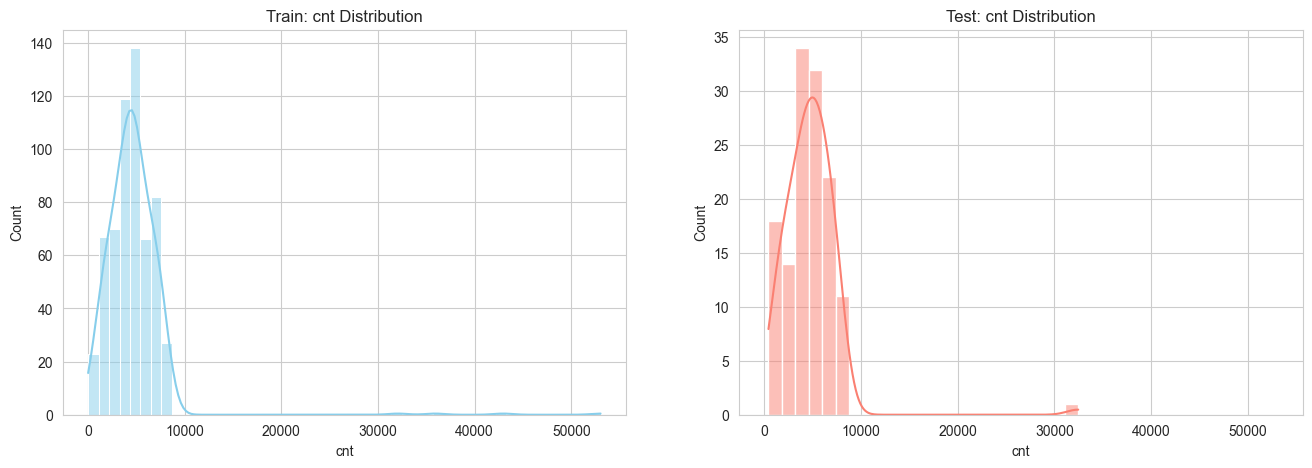

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

sns.histplot(df_train_prep['cnt'], kde=True, ax=axes[0], color='skyblue').set_title('Train: cnt Distribution')
sns.histplot(df_test_prep['cnt'], kde=True, ax=axes[1], color='salmon').set_title('Test: cnt Distribution')

plt.show()

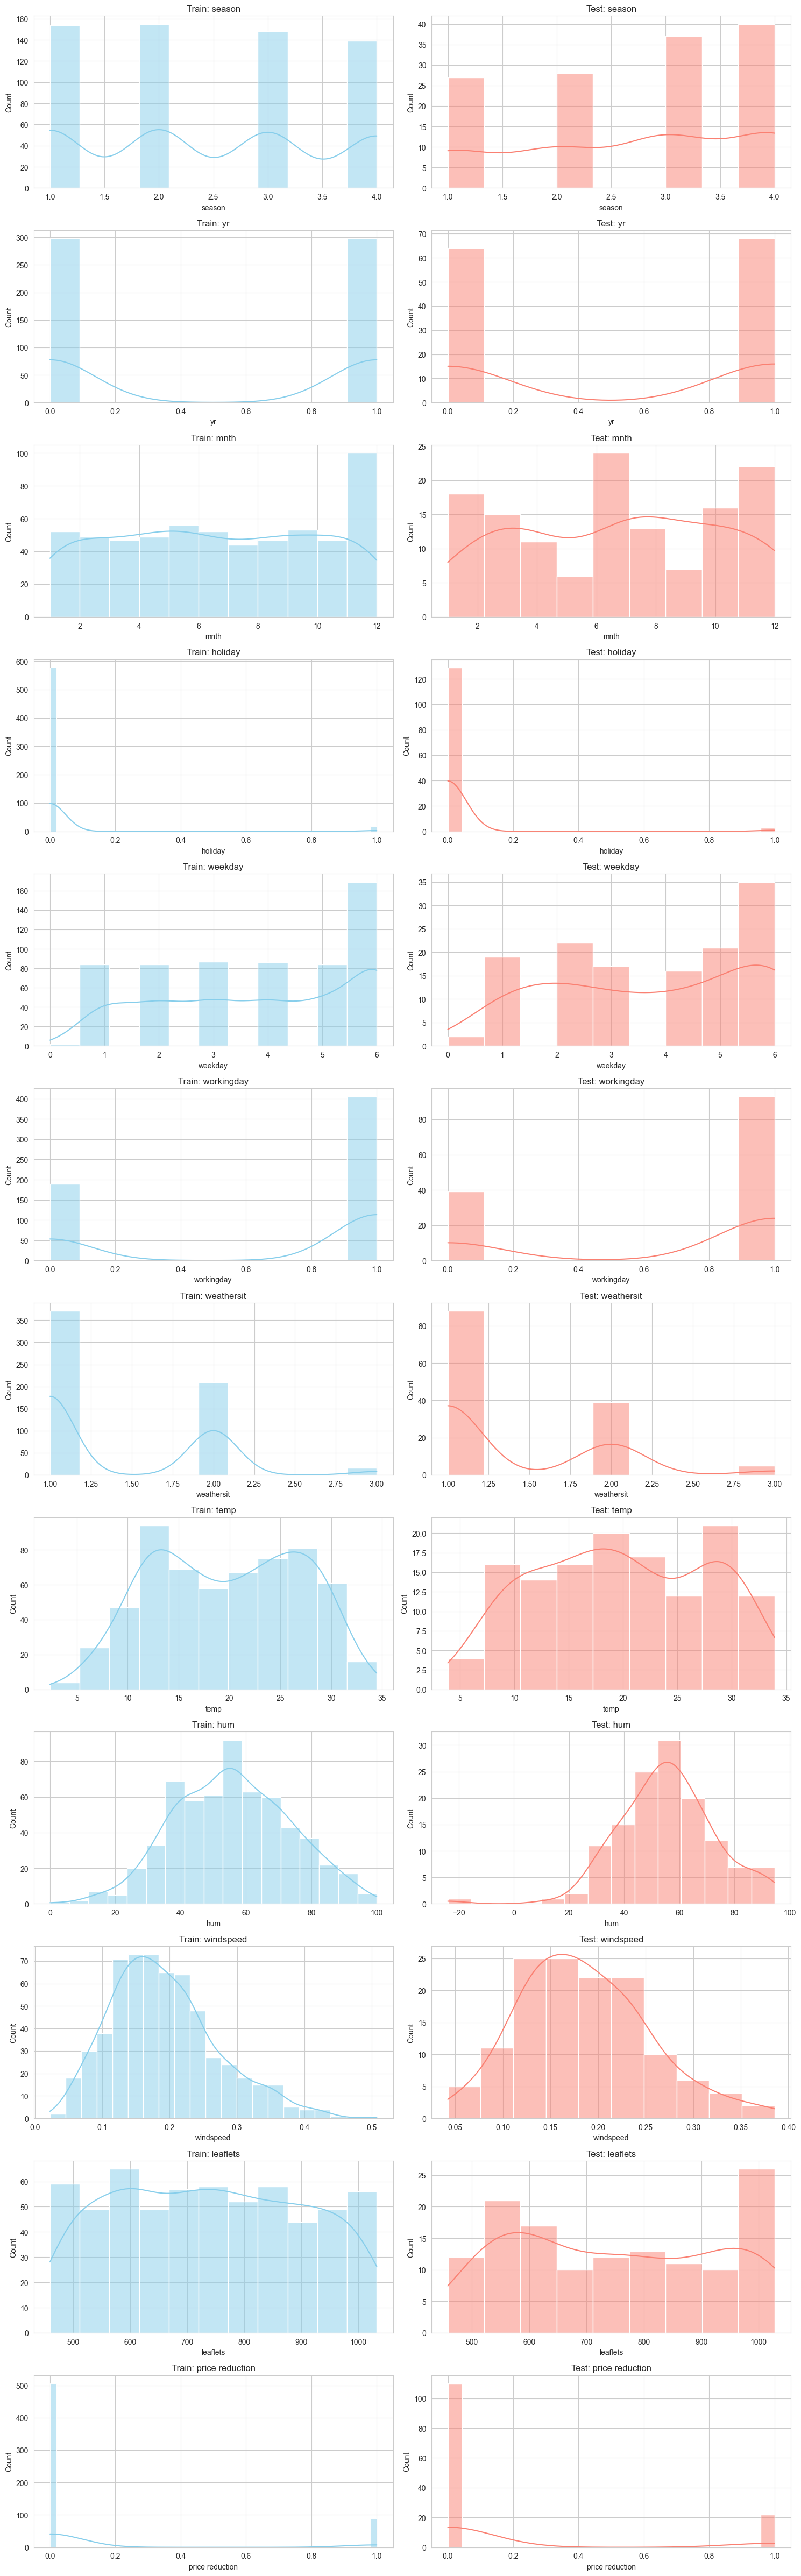

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify feature columns (everything except the target 'cnt')
features = [col for col in df_train_prep.columns if col != 'cnt']
num_features = len(features)

# 2. Create a grid of subplots
# We create a 2-column layout (Train on Left, Test on Right) for every feature
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for i, col in enumerate(features):
    # Plot Train distribution on the left
    sns.histplot(df_train_prep[col], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Train: {col}')
    
    # Plot Test distribution on the right
    sns.histplot(df_test_prep[col], kde=True, ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'Test: {col}')

# Optimize space between plots
plt.tight_layout()
plt.show()